# Data Cleaning

## 1. Accidents

In [15]:
from calendar import calendar

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
import datetime
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from config import DATA_PATH
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
import seaborn as sns
from scipy.spatial import cKDTree
import calendar
import random

In [83]:
tqdm.pandas()

In [84]:
accidents_raw = pd.read_csv('../data/raw/RoadTrafficAccidentLocations.csv')
accidents_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61058 entries, 0 to 61057
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   AccidentUID                  61058 non-null  object
 1   AccidentType                 61058 non-null  object
 2   AccidentType_de              61058 non-null  object
 3   AccidentType_fr              61058 non-null  object
 4   AccidentType_it              61058 non-null  object
 5   AccidentType_en              61058 non-null  object
 6   AccidentSeverityCategory     61058 non-null  object
 7   AccidentSeverityCategory_de  61058 non-null  object
 8   AccidentSeverityCategory_fr  61058 non-null  object
 9   AccidentSeverityCategory_it  61058 non-null  object
 10  AccidentSeverityCategory_en  61058 non-null  object
 11  AccidentInvolvingPedestrian  61058 non-null  bool  
 12  AccidentInvolvingBicycle     61058 non-null  bool  
 13  AccidentInvolvingMotorcycle  61

In [85]:
columns_to_drop = [
    "AccidentUID",
    "AccidentType_de", "AccidentType_fr", "AccidentType_it", "AccidentType_en",
    "AccidentSeverityCategory_de", "AccidentSeverityCategory_fr", "AccidentSeverityCategory_it", "AccidentSeverityCategory_en", 
    "RoadType_de", "RoadType_fr", "RoadType_it", "RoadType_en",
    "AccidentMonth_de", "AccidentMonth_fr", "AccidentMonth_it", "AccidentMonth_en", 
    "AccidentWeekDay_de", "AccidentWeekDay_fr", "AccidentWeekDay_it", "AccidentWeekDay_en", 
    "AccidentHour_text",
    "CantonCode",
    "AccidentType_de",
    "MunicipalityCode",
]

accidents = accidents_raw.drop(columns=columns_to_drop)
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61058 entries, 0 to 61057
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   AccidentType                 61058 non-null  object
 1   AccidentSeverityCategory     61058 non-null  object
 2   AccidentInvolvingPedestrian  61058 non-null  bool  
 3   AccidentInvolvingBicycle     61058 non-null  bool  
 4   AccidentInvolvingMotorcycle  61058 non-null  bool  
 5   RoadType                     61058 non-null  object
 6   AccidentLocation_CHLV95_E    61058 non-null  int64 
 7   AccidentLocation_CHLV95_N    61058 non-null  int64 
 8   AccidentYear                 61058 non-null  int64 
 9   AccidentMonth                61058 non-null  int64 
 10  AccidentWeekDay              61058 non-null  object
 11  AccidentHour                 61058 non-null  int64 
dtypes: bool(3), int64(5), object(4)
memory usage: 4.4+ MB


In [86]:
accidents.head()

,AccidentType,AccidentSeverityCategory,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,AccidentYear,AccidentMonth,AccidentWeekDay,AccidentHour
0,at0,as4,False,False,False,rt433,2682621,1245811,2011,1,aw405,8
1,at7,as4,False,False,False,rt433,2682160,1248900,2011,1,aw406,17
2,at3,as4,False,False,False,rt433,2682492,1243679,2011,1,aw404,10
3,at2,as4,False,False,False,rt432,2683032,1251966,2011,1,aw404,13
4,at7,as4,False,False,False,rt439,2683598,1253507,2011,1,aw403,10


In [87]:
# Format the Weekday column
accidents['AccidentWeekDay'] = accidents['AccidentWeekDay'].str[-1].astype(int)
# Initialize the DateTime column
accidents['DateTime'] = None

def get_month_days(year, month, weekday):
    return [day for day in range(1, calendar.monthrange(year, month)[1] + 1)
            if calendar.weekday(year, month, day) == weekday -1]

# Start with the first accident's year, month, and weekday
start_year = accidents.loc[0, 'AccidentYear']
start_month = accidents.loc[0, 'AccidentMonth']
start_weekday = accidents.loc[0, 'AccidentWeekDay']

# Calculate the first day of the month for the start date
current_date = datetime(start_year, start_month, 1)

# Adjust the current_date to the first weekday
while current_date.isoweekday() != start_weekday:
    current_date += timedelta(days=1)
    
current_date

datetime.datetime(2011, 1, 7, 0, 0)

In [88]:
# Iterate through each row to calculate the exact date
for idx, row in tqdm(accidents.iterrows(), total=len(accidents)):
    # Extract the hour and weekday
    hour = row['AccidentHour']
    weekday = row['AccidentWeekDay']
    month = row['AccidentMonth']
    year = row['AccidentYear']
    
    if (year < current_date.year) | ((month < current_date.month) & (month != 1)):
        days = get_month_days(year, month, weekday)
        day = days[random.randint(0, len(days) - 1)]
        imputed_date = datetime(year, month, day)
        current_date = imputed_date
        accidents.at[idx, 'DateTime'] = imputed_date.replace(hour=hour)

    # If the month changes, reset the current_date
    if current_date.month != month:
        current_date = datetime(year, month, 1)
        while current_date.isoweekday() != weekday:
            current_date += timedelta(days=1)

    # If the weekday changes, increment the date
    while current_date.isoweekday() != weekday:
        current_date += timedelta(days=1)
        if current_date.month != month:
             current_date = datetime(year, month, 1)

    # Set the DateTime column
    accidents.at[idx, 'DateTime'] = current_date.replace(hour=hour)

  0%|          | 0/61058 [00:00<?, ?it/s]

In [90]:
accidents.rename(columns={'DateTime': 'dateTime', 'AccidentHour': 'hour', 'AccidentWeekDay': 'weekday', 'AccidentMonth': 'month', 'AccidentYear': 'year', 'AccidentLocation_CHLV95_E': 'x', 'AccidentLocation_CHLV95_N': 'y'}, inplace=True)
accidents = accidents[accidents['dateTime'] >= pd.Timestamp('2012-01-01')]


In [94]:
accidents.to_csv("../data/clean/accidents_clean.csv", index=False)

## 2. Traffic Volume

In [63]:
traffic_volume_example = pd.read_csv('../data/raw/sid_dav_verkehrszaehlung_miv_OD2031_2024.csv')
traffic_volume_example.info()

C:\Users\ogetg\AppData\Local\Temp\ipykernel_22012\3482216889.py:1: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic_volume_example = pd.read_csv('../data/raw/sid_dav_verkehrszaehlung_miv_OD2031_2024.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603021 entries, 0 to 1603020
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   MSID                1603021 non-null  object 
 1   MSName              1603021 non-null  object 
 2   ZSID                1603021 non-null  object 
 3   ZSName              1603021 non-null  object 
 4   Achse               1603021 non-null  object 
 5   HNr                 1603021 non-null  object 
 6   Hoehe               1603021 non-null  object 
 7   EKoord              1603021 non-null  float64
 8   NKoord              1603021 non-null  float64
 9   Richtung            1603021 non-null  object 
 10  Knummer             1603021 non-null  int64  
 11  Kname               1603021 non-null  object 
 12  AnzDetektoren       1603021 non-null  int64  
 13  D1ID                1603021 non-null  int64  
 14  D2ID                1603021 non-null  object 
 15  D3ID           

In [64]:
traffic_volume_example

,MSID,MSName,ZSID,ZSName,Achse,HNr,Hoehe,EKoord,NKoord,Richtung,...,Kname,AnzDetektoren,D1ID,D2ID,D3ID,D4ID,MessungDatZeit,LieferDat,AnzFahrzeuge,AnzFahrzeugeStatus
0,Z001M001,Unbekannt,Z001,Seestrasse (Strandbad Wollishofen),Seestrasse,451,Unbekannt,2683009.890,1243936.200,auswärts,...,Badanstalt Wollishofen,1,2,Unbekannt,Unbekannt,Unbekannt,2024-01-01T00:00:00,2024-11-23,178.0,Gemessen
1,Z001M001,Unbekannt,Z001,Seestrasse (Strandbad Wollishofen),Seestrasse,451,Unbekannt,2683009.890,1243936.200,auswärts,...,Badanstalt Wollishofen,1,2,Unbekannt,Unbekannt,Unbekannt,2024-01-01T01:00:00,2024-11-23,380.0,Gemessen
2,Z001M001,Unbekannt,Z001,Seestrasse (Strandbad Wollishofen),Seestrasse,451,Unbekannt,2683009.890,1243936.200,auswärts,...,Badanstalt Wollishofen,1,2,Unbekannt,Unbekannt,Unbekannt,2024-01-01T02:00:00,2024-11-23,143.0,Gemessen
3,Z001M001,Unbekannt,Z001,Seestrasse (Strandbad Wollishofen),Seestrasse,451,Unbekannt,2683009.890,1243936.200,auswärts,...,Badanstalt Wollishofen,1,2,Unbekannt,Unbekannt,Unbekannt,2024-01-01T03:00:00,2024-11-23,81.0,Gemessen
4,Z001M001,Unbekannt,Z001,Seestrasse (Strandbad Wollishofen),Seestrasse,451,Unbekannt,2683009.890,1243936.200,auswärts,...,Badanstalt Wollishofen,1,2,Unbekannt,Unbekannt,Unbekannt,2024-01-01T04:00:00,2024-11-23,70.0,Gemessen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603016,Z111M002,Unbekannt,Z111,Hagenholzstrasse (Riedgrabenweg),Hagenholstrasse,Unbekannt,nach Riedgrabenweg,2684519.786,1252129.416,einwärts (ohne Busse),...,Hagenholzstr/Riedgrabenweg,1,13,Unbekannt,Unbekannt,Unbekannt,2024-11-22T19:00:00,2024-11-23,NaN,Fehlend
1603017,Z111M002,Unbekannt,Z111,Hagenholzstrasse (Riedgrabenweg),Hagenholstrasse,Unbekannt,nach Riedgrabenweg,2684519.786,1252129.416,einwärts (ohne Busse),...,Hagenholzstr/Riedgrabenweg,1,13,Unbekannt,Unbekannt,Unbekannt,2024-11-22T20:00:00,2024-11-23,NaN,Fehlend
1603018,Z111M002,Unbekannt,Z111,Hagenholzstrasse (Riedgrabenweg),Hagenholstrasse,Unbekannt,nach Riedgrabenweg,2684519.786,1252129.416,einwärts (ohne Busse),...,Hagenholzstr/Riedgrabenweg,1,13,Unbekannt,Unbekannt,Unbekannt,2024-11-22T21:00:00,2024-11-23,NaN,Fehlend
1603019,Z111M002,Unbekannt,Z111,Hagenholzstrasse (Riedgrabenweg),Hagenholstrasse,Unbekannt,nach Riedgrabenweg,2684519.786,1252129.416,einwärts (ohne Busse),...,Hagenholzstr/Riedgrabenweg,1,13,Unbekannt,Unbekannt,Unbekannt,2024-11-22T22:00:00,2024-11-23,NaN,Fehlend


In [96]:
# Define column data types for efficient memory usage
column_data_types = {
    'HNr': str,
    'D2ID': str,
    'MSID': str,
    'ZSID': str,
    'Richtung': str,
}

# Function to read and clean traffic data for a specific year
def read_traffic_data(year):
    filename = os.path.join(DATA_PATH, "raw", f"sid_dav_verkehrszaehlung_miv_OD2031_{year}.csv")
    df = pd.read_csv(
        filename,
        dtype=column_data_types,
        usecols=['MSID', 'EKoord', 'NKoord', 'MessungDatZeit', 'AnzFahrzeuge'],
        parse_dates=['MessungDatZeit']
    )
    
    # Optimize numeric columns
    df['AnzFahrzeuge'] = pd.to_numeric(df['AnzFahrzeuge'], downcast='integer')
    df['EKoord'] = pd.to_numeric(df['EKoord'], downcast='float')
    df['NKoord'] = pd.to_numeric(df['NKoord'], downcast='float')
    
    return df

# Load traffic data for multiple years concurrently
trafficdic = {}

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(read_traffic_data, year): year for year in range(2012, 2024)}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Traffic Data"):
        year = futures[future]
        try:
            trafficdic[year] = future.result()
        except Exception as e:
            print(f"Error processing year {year}: {e}")
            
# Combine all traffic data into a single DataFrame
traffic_data = pd.concat(trafficdic.values(), ignore_index=True)

Processing Traffic Data:   0%|          | 0/12 [00:00<?, ?it/s]

In [97]:
# Convert MSID to integers
traffic_data['MSID'], msid_mapping = pd.factorize(traffic_data['MSID'])

# Create a dictionary with MSID as keys and EKoord, NKoord as values
coordinates_dict = (
    traffic_data[['MSID', 'EKoord', 'NKoord']]
    .drop_duplicates(subset='MSID')  # Ensure unique MSID
    .set_index('MSID')  # Set MSID as the index
    .to_dict('index')  # Convert to dictionary with MSID as keys
)

# Format the dictionary to ensure values are tuples of coordinates
coordinates_dict = {msid: (coords['EKoord'], coords['NKoord']) for msid, coords in coordinates_dict.items()}

traffic_data

,MSID,EKoord,NKoord,MessungDatZeit,AnzFahrzeuge
0,0,2683009.89,1243936.20,2013-01-01 00:00:00,224.0
1,0,2683009.89,1243936.20,2013-01-01 01:00:00,547.0
2,0,2683009.89,1243936.20,2013-01-01 02:00:00,249.0
3,0,2683009.89,1243936.20,2013-01-01 03:00:00,123.0
4,0,2683009.89,1243936.20,2013-01-01 04:00:00,95.0
...,...,...,...,...,...
18329131,206,2685785.92,1245472.68,2023-12-31 19:00:00,20.0
18329132,206,2685785.92,1245472.68,2023-12-31 20:00:00,18.0
18329133,206,2685785.92,1245472.68,2023-12-31 21:00:00,17.0
18329134,206,2685785.92,1245472.68,2023-12-31 22:00:00,20.0


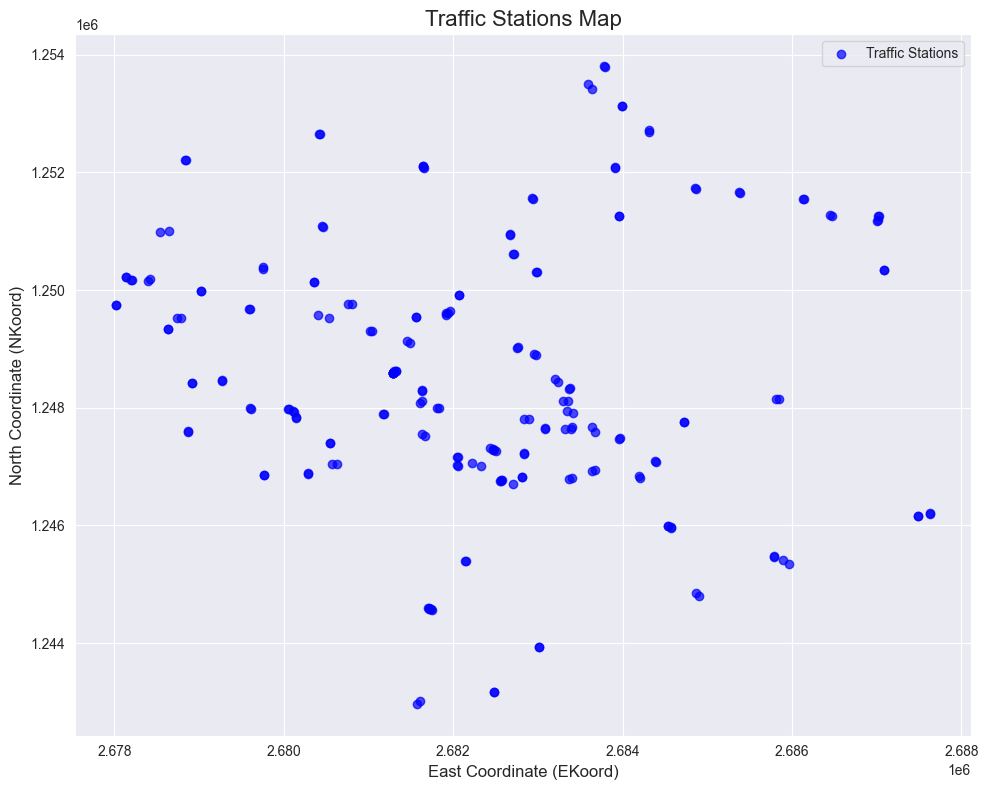

In [98]:
import matplotlib.pyplot as plt

# Extract coordinates from the dictionary
coordinates = pd.DataFrame.from_dict(coordinates_dict, orient='index', columns=['EKoord', 'NKoord'])

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(coordinates['EKoord'], coordinates['NKoord'], c='blue', alpha=0.7, label='Traffic Stations')

# Customize the plot
plt.title('Traffic Stations Map', fontsize=16)
plt.xlabel('East Coordinate (EKoord)', fontsize=12)
plt.ylabel('North Coordinate (NKoord)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [99]:
def trim_missing_data(df):
    """
    Removes missing values at the start and end for each MSID in the dataset.
    
    Args:
        df (pd.DataFrame): Traffic data with columns 'MSID' and 'AnzFahrzeuge'.
    
    Returns:
        pd.DataFrame: Trimmed DataFrame with missing start/end values removed.
    """
    trimmed_data = []

    # Group by MSID and process each group
    for msid, group in df.groupby('MSID'):
        # Find the first and last valid indices
        first_valid = group['AnzFahrzeuge'].first_valid_index()
        last_valid = group['AnzFahrzeuge'].last_valid_index()
        
        # Trim the data for this MSID
        trimmed_group = group.loc[first_valid:last_valid]
        trimmed_data.append(trimmed_group)

    # Combine all trimmed groups into a single DataFrame
    return pd.concat(trimmed_data, ignore_index=True)

# Apply the function to the traffic_data DataFrame
traffic_data = trim_missing_data(traffic_data)

In [100]:
# Count total and missing values for each counting station (identified by MSID)
missing_counts = (
    traffic_data.groupby('MSID')['AnzFahrzeuge']
    .apply(lambda x: x.isna().sum())  # Count missing values for 'AnzFahrzeuge'
    .reset_index(name='MissingCount')
)

total_counts = (
    traffic_data['MSID']
    .value_counts()  # Count total occurrences for each MSID
    .reset_index(name='TotalCount')
    .rename(columns={'index': 'MSID'})
)

# Merge missing and total counts
missing_stats = pd.merge(missing_counts, total_counts, on='MSID')
missing_stats['MissingPercentage'] = (missing_stats['MissingCount'] / missing_stats['TotalCount']) * 100

# Sort by the highest percentage of missing values
missing_stats = missing_stats.sort_values(by='MissingPercentage', ascending=False)

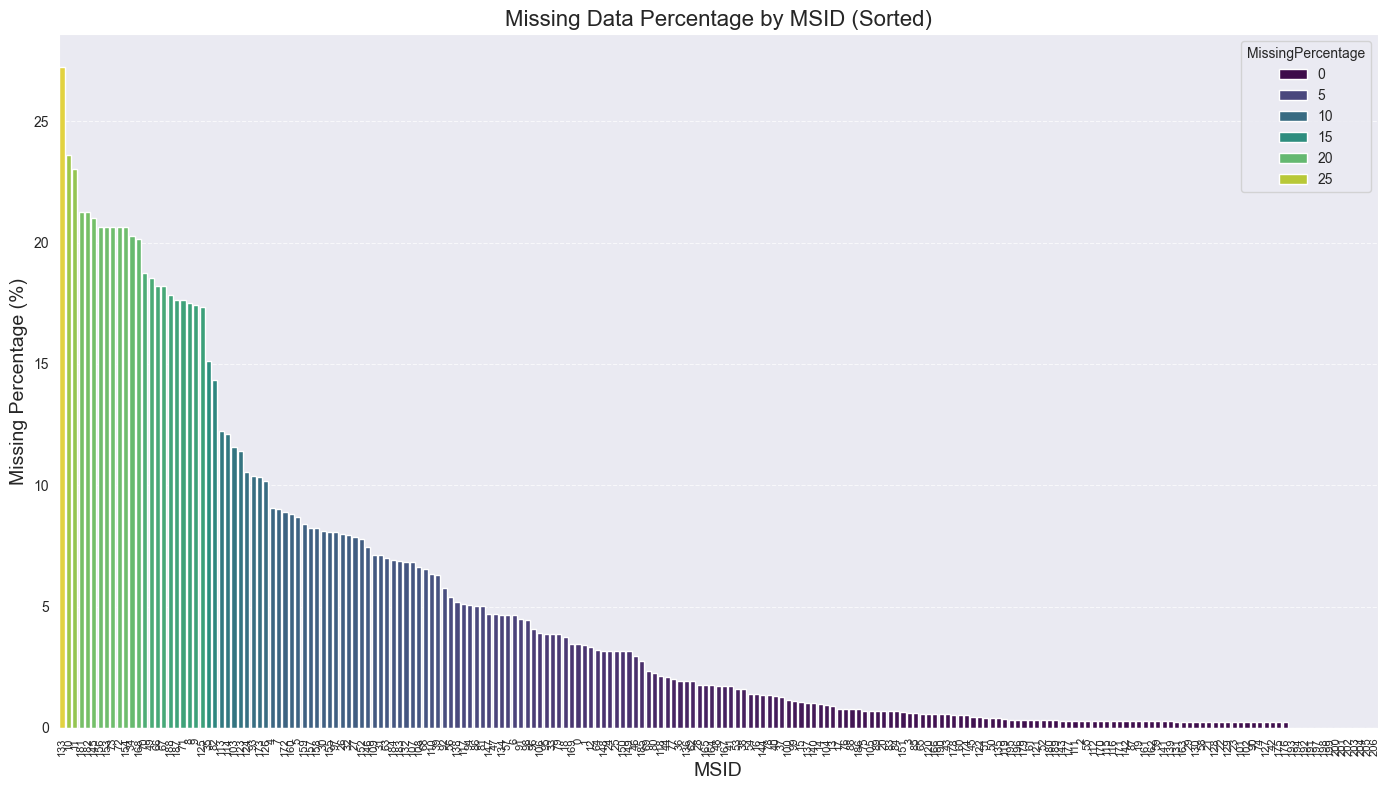

In [101]:
import seaborn as sns

# Plot the sorted MissingPercentage by MSID
plt.figure(figsize=(14, 8))
sns.barplot(
    x=missing_stats['MSID'], 
    y=missing_stats['MissingPercentage'], 
    order=missing_stats['MSID'],  # Maintain sorting
    palette="viridis", hue=missing_stats['MissingPercentage']
)

# Customize the plot
plt.title('Missing Data Percentage by MSID (Sorted)', fontsize=16)
plt.xlabel('MSID', fontsize=14)
plt.ylabel('Missing Percentage (%)', fontsize=14)
plt.xticks(rotation=90, fontsize=8)  # Rotate MSID labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


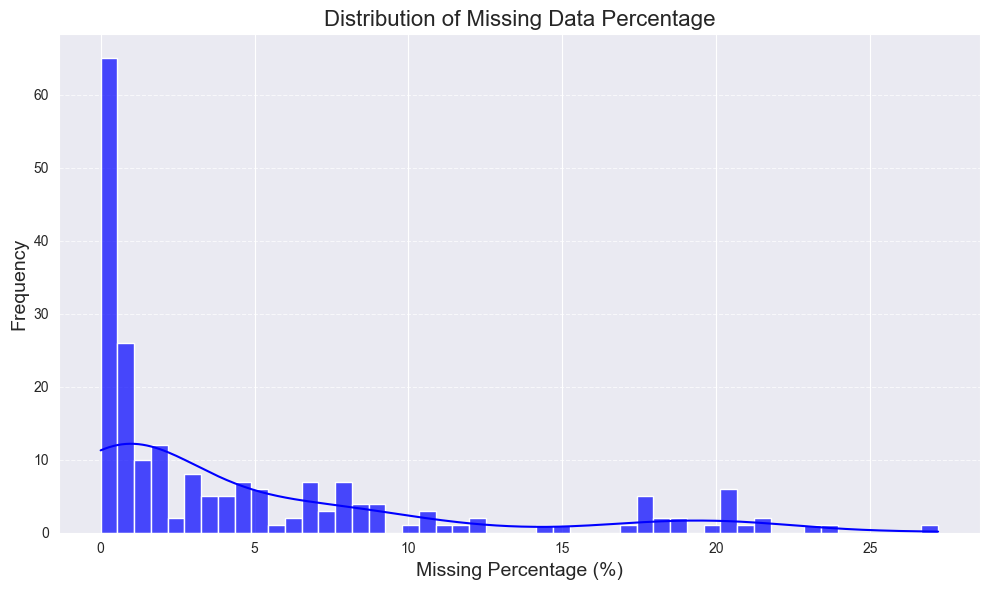

In [102]:
plt.figure(figsize=(10, 6))
sns.histplot(missing_stats['MissingPercentage'], bins=50, kde=True, color='blue', alpha=0.7)

# Customize the plot
plt.title('Distribution of Missing Data Percentage', fontsize=16)
plt.xlabel('Missing Percentage (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [103]:
# Drop rows where data is anomalous
traffic_data = traffic_data[traffic_data['MSID'] != 145]
missing_stats = missing_stats[missing_stats['MSID'] != 145]
traffic_data = traffic_data[traffic_data['MSID'] != 133]
missing_stats = missing_stats[missing_stats['MSID'] != 133]

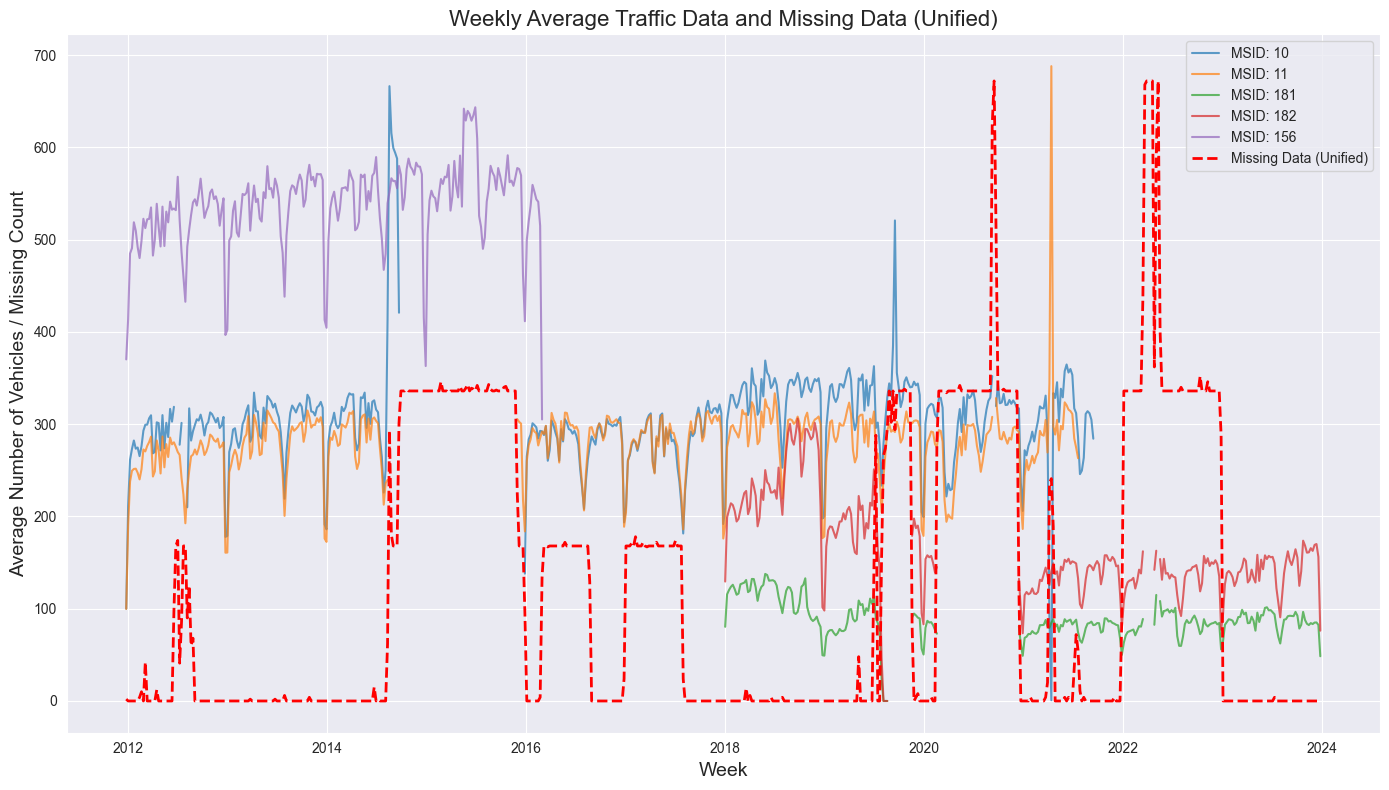

In [104]:
# Select top 10 MSIDs with the most missing data
top_msids = missing_stats['MSID'].head(5).tolist()

# Filter data for the selected MSIDs and create a copy to avoid SettingWithCopyWarning
filtered_data = traffic_data[traffic_data['MSID'].isin(top_msids)].copy()

# Convert to weekly periods
filtered_data['Week'] = filtered_data['MessungDatZeit'].dt.to_period('W')  # Convert to weekly periods

# Calculate weekly averages for each MSID
weekly_averages = (
    filtered_data.groupby(['MSID', 'Week'])['AnzFahrzeuge']
    .mean()
    .reset_index()
)
weekly_averages['Week'] = weekly_averages['Week'].dt.start_time  # Convert back to datetime for plotting

# Combine all missing data into one unified series
filtered_data['IsMissing'] = filtered_data['AnzFahrzeuge'].isna()
missing_data = (
    filtered_data.groupby('Week')['IsMissing']
    .sum()
    .reset_index()
    .rename(columns={'IsMissing': 'MissingCount'})
)
missing_data['Week'] = missing_data['Week'].dt.start_time

# Plot weekly averages for each MSID
plt.figure(figsize=(14, 8))
for msid in top_msids:
    msid_data = weekly_averages[weekly_averages['MSID'] == msid]
    
    # Plot weekly averages
    plt.plot(
        msid_data['Week'],
        msid_data['AnzFahrzeuge'],
        label=f"MSID: {msid}",
        alpha=0.7,  # Adjust transparency
        linestyle="-",
        linewidth=1.5
    )

# Plot unified missing data line
plt.plot(
    missing_data['Week'],
    missing_data['MissingCount'],
    color='red',
    label='Missing Data (Unified)',
    linestyle="--",
    linewidth=2
)

# Customize the plot
plt.title("Weekly Average Traffic Data and Missing Data (Unified)", fontsize=16)
plt.xlabel("Week", fontsize=14)
plt.ylabel("Average Number of Vehicles / Missing Count", fontsize=14)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [105]:
def impute_missing_values_ignore_year(data):
    """
    Impute missing values by assigning each NaN the average of all values 
    for the same MSID and time of day (ignoring the year).

    Args:
        data (pd.DataFrame): The dataset containing MSID, MessungDatZeit, and AnzFahrzeuge.

    Returns:
        pd.DataFrame: The dataset with imputed values.
    """

    # Ensure MessungDatZeit is in datetime format
    data['MessungDatZeit'] = pd.to_datetime(data['MessungDatZeit'])

    # Extract month, day, and time (ignoring the year)
    data['TimeKey'] = data['MessungDatZeit'].dt.strftime('%m-%d %H:%M:%S')

    # Group by MSID and TimeKey, calculate the mean for AnzFahrzeuge
    grouped_means = (
        data.groupby(['MSID', 'TimeKey'])['AnzFahrzeuge']
        .mean()
        .reset_index()
        .rename(columns={'AnzFahrzeuge': 'MeanValue'})
    )

    # Merge the calculated means back into the original DataFrame
    data = pd.merge(data, grouped_means, on=['MSID', 'TimeKey'], how='left')

    # Fill NaN values in AnzFahrzeuge with the corresponding MeanValue
    data['AnzFahrzeuge'] = data['AnzFahrzeuge'].fillna(data['MeanValue'])

    # Drop the auxiliary columns
    data = data.drop(columns=['MeanValue', 'TimeKey'])

    return data

# Apply the function
imputed_data = impute_missing_values_ignore_year(traffic_data)

In [106]:
imputed_data['AnzFahrzeuge'].isna().sum()

214

In [107]:
imputed_data = imputed_data.dropna()

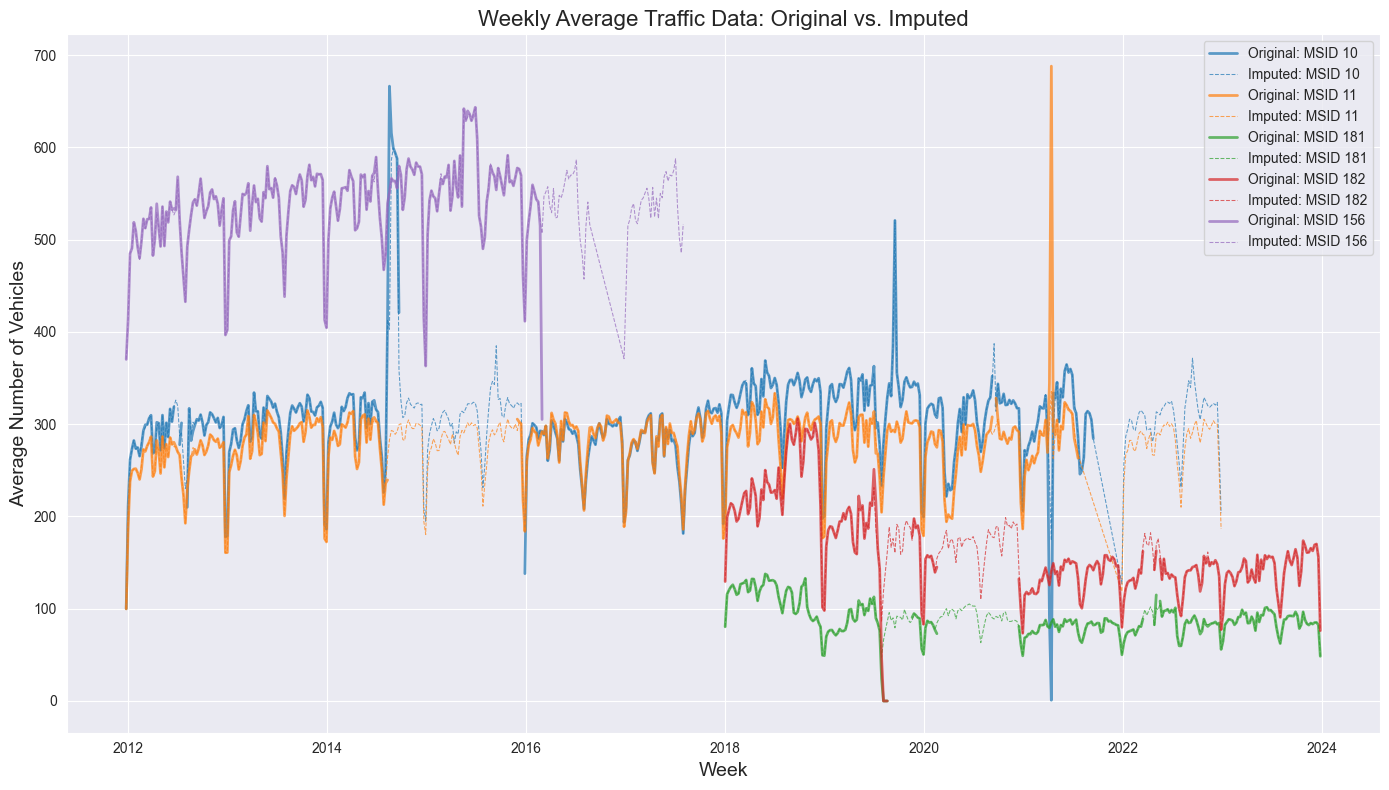

In [108]:
# Select top 5 MSIDs with the most missing data
top_msids = missing_stats['MSID'].head(5).tolist()

# Filter data for the selected MSIDs
original_data_filtered = traffic_data[traffic_data['MSID'].isin(top_msids)].copy()
imputed_data_filtered = imputed_data[imputed_data['MSID'].isin(top_msids)].copy()

# Convert to weekly periods for both datasets
original_data_filtered['Week'] = original_data_filtered['MessungDatZeit'].dt.to_period('W')
imputed_data_filtered['Week'] = imputed_data_filtered['MessungDatZeit'].dt.to_period('W')

# Calculate weekly averages for each MSID in both datasets
weekly_averages_original = (
    original_data_filtered.groupby(['MSID', 'Week'])['AnzFahrzeuge']
    .mean()
    .reset_index()
)
weekly_averages_original['Week'] = weekly_averages_original['Week'].dt.start_time

weekly_averages_imputed = (
    imputed_data_filtered.groupby(['MSID', 'Week'])['AnzFahrzeuge']
    .mean()
    .reset_index()
)
weekly_averages_imputed['Week'] = weekly_averages_imputed['Week'].dt.start_time

# Combine all missing data into one unified series for original data
original_data_filtered['IsMissing'] = original_data_filtered['AnzFahrzeuge'].isna()
missing_data = (
    original_data_filtered.groupby('Week')['IsMissing']
    .sum()
    .reset_index()
    .rename(columns={'IsMissing': 'MissingCount'})
)
missing_data['Week'] = missing_data['Week'].dt.start_time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generate a colormap with len(top_msids) discrete colors
colors = plt.colormaps['tab10']  # Get the colormap object
color_list = [colors(i / len(top_msids)) for i in range(len(top_msids))]

# Plot weekly averages for each MSID
plt.figure(figsize=(14, 8))
for idx, msid in enumerate(top_msids):
    # Assign color from the colormap
    color = colors(idx)
    
    # Original data
    msid_data_original = weekly_averages_original[weekly_averages_original['MSID'] == msid]
    plt.plot(
        msid_data_original['Week'],
        msid_data_original['AnzFahrzeuge'],
        label=f"Original: MSID {msid}",
        color=color,  # Use the assigned color
        alpha=0.7,
        linestyle="-",
        linewidth=2
    )
    
    # Imputed data
    msid_data_imputed = weekly_averages_imputed[weekly_averages_imputed['MSID'] == msid]
    plt.plot(
        msid_data_imputed['Week'],
        msid_data_imputed['AnzFahrzeuge'],
        label=f"Imputed: MSID {msid}",
        color=color,  # Use the same color
        alpha=0.7,
        linestyle="--",
        linewidth=0.75
    )

# Customize the plot
plt.title("Weekly Average Traffic Data: Original vs. Imputed", fontsize=16)
plt.xlabel("Week", fontsize=14)
plt.ylabel("Average Number of Vehicles", fontsize=14)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [109]:
imputed_data.rename(columns={'MSID': 'ID', 'MessungDatZeit': 'dateTime', 'AnzFahrzeuge': 'volume', 'EKoord': 'x', 'NKoord': 'y'}, inplace=True)

In [110]:
imputed_data.to_csv('../data/clean/traffic_clean.csv', index=False)

## Pedestrian and Bicycle Volume

In [80]:
pd.read_csv('../data/raw/2024_verkehrszaehlungen_werte_fussgaenger_velo.csv')['DATUM']

0         2024-01-01T00:00
1         2024-01-01T00:00
2         2024-01-01T00:00
3         2024-01-01T00:00
4         2024-01-01T00:00
                ...       
822583    2024-11-23T23:45
822584    2024-11-23T23:45
822585    2024-11-23T23:45
822586    2024-11-23T23:45
822587    2024-11-23T23:45
Name: DATUM, Length: 822588, dtype: object

In [81]:
def read_pedestrian_data(year):
    filename = os.path.join(DATA_PATH, "raw", f"{year}_verkehrszaehlungen_werte_fussgaenger_velo.csv")
    df = pd.read_csv(
        filename,
        usecols=['FK_STANDORT', 'OST', 'NORD', 'DATUM', 'VELO_IN', 'VELO_OUT', 'FUSS_IN', 'FUSS_OUT']
    )
    
    return df

pedestrian_dict = {}

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(read_pedestrian_data, year): year for year in range(2012, 2023)}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Traffic Data"):
        year = futures[future]
        try:
            pedestrian_dict[year] = future.result()
        except Exception as e:
            print(f"Error processing year {year}: {e}")
            
# Combine all traffic data into a single DataFrame
pedestrian_data = pd.concat(pedestrian_dict.values(), ignore_index=True)

Processing Traffic Data:   0%|          | 0/11 [00:00<?, ?it/s]

In [82]:
pedestrian_data['DATUM'] = pd.to_datetime(pedestrian_data['DATUM'])

In [83]:
pedestrian_data

,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD
0,6,2012-01-01 00:00:00,1.0,1.0,NaN,NaN,2682873,1245891
1,12,2012-01-01 00:00:00,1.0,1.0,NaN,NaN,2681385,1247736
2,13,2012-01-01 00:00:00,0.0,NaN,NaN,NaN,2682683,1250570
3,54,2012-01-01 00:00:00,1.0,1.0,NaN,NaN,2684006,1246566
4,5,2012-01-01 00:00:00,0.0,0.0,NaN,NaN,2682933,1248821
...,...,...,...,...,...,...,...,...
11967380,65,2018-12-31 23:45:00,NaN,NaN,0.0,1.0,2679174,1249438
11967381,2642,2018-12-31 23:45:00,NaN,NaN,16.0,9.0,2683020,1244136
11967382,53,2018-12-31 23:45:00,0.0,0.0,0.0,0.0,2679028,1250674
11967383,394,2018-12-31 23:45:00,NaN,NaN,13.0,3.0,2683573,1251687


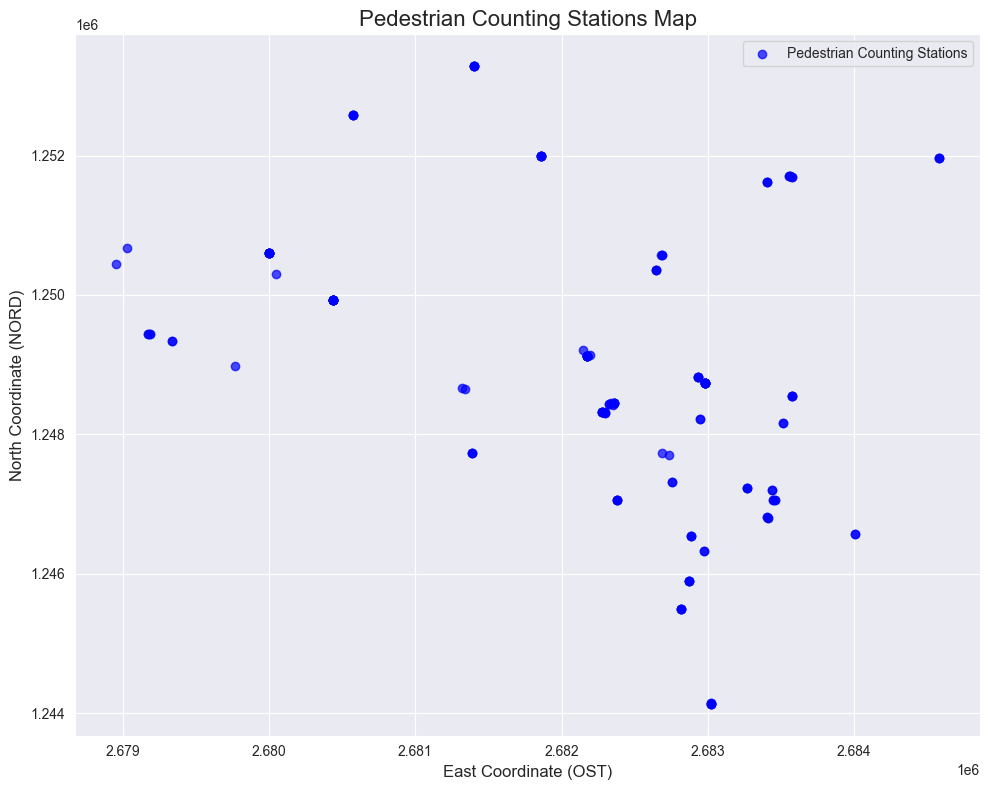

In [84]:
# Convert FK_STANDORT to integers
pedestrian_data['FK_STANDORT'], standort_mapping = pd.factorize(pedestrian_data['FK_STANDORT'])

# Create a dictionary with FK_STANDORT as keys and OST, NORD as values
coordinates_dict = (
    pedestrian_data[['FK_STANDORT', 'OST', 'NORD']]
    .drop_duplicates(subset='FK_STANDORT')  # Ensure unique FK_STANDORT
    .set_index('FK_STANDORT')  # Set FK_STANDORT as the index
    .to_dict('index')  # Convert to dictionary with FK_STANDORT as keys
)

# Format the dictionary to ensure values are tuples of coordinates
coordinates_dict = {standort: (coords['OST'], coords['NORD']) for standort, coords in coordinates_dict.items()}

# Extract coordinates from the dictionary
coordinates = pd.DataFrame.from_dict(coordinates_dict, orient='index', columns=['OST', 'NORD'])

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(coordinates['OST'], coordinates['NORD'], c='blue', alpha=0.7, label='Pedestrian Counting Stations')

# Customize the plot
plt.title('Pedestrian Counting Stations Map', fontsize=16)
plt.xlabel('East Coordinate (OST)', fontsize=12)
plt.ylabel('North Coordinate (NORD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [85]:
numeric_features = ['VELO_IN', 'VELO_OUT', 'FUSS_IN', 'FUSS_OUT']
missing_df = pd.DataFrame({'FK_STANDORT': pedestrian_data['FK_STANDORT'].unique()})

for feature in numeric_features:
    # Count total and missing values for each counting station (identified by FK_STANDORT)
    missing_counts = (
        pedestrian_data.groupby('FK_STANDORT')[feature]
        .apply(lambda x: x.isna().sum())  # Count missing values across all columns
        .reset_index(name=f'{feature}_MissingCount')
    )
    
    total_counts = (
        pedestrian_data['FK_STANDORT']
        .value_counts()  # Count total occurrences for each FK_STANDORT
        .reset_index(name='TotalCount')
        .rename(columns={'index': 'FK_STANDORT'})
    )
    
    # Merge missing counts and total counts
    counts_df = pd.merge(missing_counts, total_counts, on='FK_STANDORT')

    # Calculate missing percentage
    counts_df[f'{feature}_MissingPercentage'] = (
        counts_df[f'{feature}_MissingCount'] / counts_df['TotalCount']
    )

    # Merge the missing percentage into the final DataFrame
    missing_df = pd.merge(
        missing_df,
        counts_df[['FK_STANDORT', f'{feature}_MissingPercentage']],
        on='FK_STANDORT',
        how='left'
    )

In [86]:
missing_df

,FK_STANDORT,VELO_IN_MissingPercentage,VELO_OUT_MissingPercentage,FUSS_IN_MissingPercentage,FUSS_OUT_MissingPercentage
0,0,0.0,0.000000,1.0,1.0
1,1,0.0,0.000000,1.0,1.0
2,2,0.0,0.997683,1.0,1.0
3,3,0.0,0.000000,1.0,1.0
4,4,0.0,0.000000,1.0,1.0
...,...,...,...,...,...
151,151,1.0,1.000000,0.0,0.0
152,152,1.0,1.000000,0.0,0.0
153,153,1.0,1.000000,0.0,0.0
154,154,0.0,0.000000,1.0,1.0


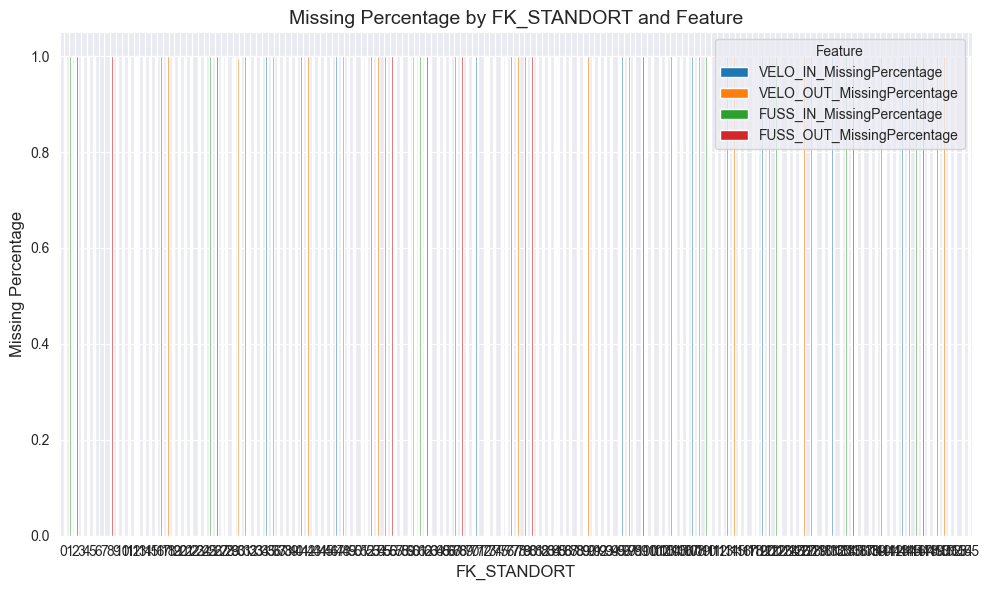

In [87]:
# Plot the values in a bar plot
ax = missing_df.set_index('FK_STANDORT').plot(
    kind='bar',
    figsize=(10, 6),
    width=0.8
)

# Customizing the plot
plt.title('Missing Percentage by FK_STANDORT and Feature', fontsize=14)
plt.xlabel('FK_STANDORT', fontsize=12)
plt.ylabel('Missing Percentage', fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Feature', fontsize=10)
plt.tight_layout()

plt.show()

In [88]:
pedestrian_data = pedestrian_data.fillna(0)

In [89]:
pedestrian_data['volume'] = pedestrian_data[['VELO_IN', 'VELO_OUT', 'FUSS_IN', 'FUSS_OUT']].sum(axis=1)
pedestrian_data.drop(columns=['VELO_IN', 'VELO_OUT', 'FUSS_IN', 'FUSS_OUT'], inplace=True)

In [90]:
pedestrian_data.rename(columns={'FK_STANDORT': 'ID', 'DATUM': 'dateTime', 'OST': 'x', 'NORD': 'y'}, inplace=True)

In [91]:
pedestrian_data.to_csv('../data/clean/pedestrian_clean.csv', index=False)

## 3. Weather Data

In [96]:
weather_data = pd.read_csv('../data/raw/weather_data.csv')

In [97]:
weather_data['dateTime'] = pd.to_datetime(weather_data['time'])
weather_data.drop(columns=['time'], inplace=True)

In [98]:
weather_data.to_csv('../data/clean/weather_clean.csv', index=False)

## 4. Average Volume

In [ ]:
pedestrian = pd.read_csv('../data/clean/pedestrian_clean.csv')
traffic = pd.read_csv('../data/clean/traffic_clean.csv')

In [21]:
def average_volume(df):
    df = df.copy()
    
    # 2. Convert 'dateTime' to Datetime Format
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    
    # 3. Extract 'month', 'weekday', and 'hour' from 'dateTime'
    df['month'] = df['dateTime'].dt.month
    df['weekday'] = df['dateTime'].dt.isocalendar().day  # Monday=1, Sunday=7
    df['hour'] = df['dateTime'].dt.hour
    
    # 4. Group by 'month', 'weekday', and 'hour' and Calculate Mean 'volume'
    aggregated_df = df.groupby(['month', 'weekday', 'hour'])['volume'].mean().reset_index()
    
    # 5. (Optional) Rename Columns for Clarity
    aggregated_df.rename(columns={'volume': 'mean_volume'}, inplace=True)
    
    # 6. Display the Aggregated DataFrame
    print(aggregated_df.head())
    
    return aggregated_df

In [22]:
average_traffic = average_volume(traffic).rename(columns={'mean_volume': 'traffic'})
average_pedestrian = average_volume(pedestrian).rename(columns={'mean_volume': 'pedestrian'})

   month  weekday  hour  mean_volume
0      1        1     0    62.375059
1      1        1     1    44.714321
2      1        1     2    33.589331
3      1        1     3    34.865830
4      1        1     4    59.648966
   month  weekday  hour  mean_volume
0      1        1     0     1.991784
1      1        1     1     1.313836
2      1        1     2     0.812436
3      1        1     3     0.620601
4      1        1     4     0.719337


In [29]:
average_volume = pd.merge(average_traffic, average_pedestrian, on=['month', 'weekday', 'hour'])
average_volume['traffic'] = average_volume['traffic'].astype('int')
average_volume['pedestrian'] = average_volume['pedestrian'].astype('int')

In [30]:
average_volume

,month,weekday,hour,traffic,pedestrian
0,1,1,0,62,1
1,1,1,1,44,1
2,1,1,2,33,0
3,1,1,3,34,0
4,1,1,4,59,0
...,...,...,...,...,...
2011,12,7,19,337,12
2012,12,7,20,285,9
2013,12,7,21,244,7
2014,12,7,22,202,6


In [31]:
average_volume.to_csv('../data/inference/average_volume.csv', index=False)